<a href="https://colab.research.google.com/github/gibi177/NOIA/blob/main/Reconhecimento_de_digital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecimento de digital

## Trabalho final da disciplina Noções de Inteligência Artificial - 2/2024
## Alunos: Felipe Lopes Gibin Duarte (231025207) e Matheus das Neves Fernandes (231013672)


## Introdução

A biometria tem se consolidado como uma das tecnologias mais confiáveis e seguras para autenticação e identificação de indivíduos. Dentre as modalidades de biometria, o reconhecimento de impressões digitais se destaca pela ampla adoção e alta confiabilidade.

Neste trabalho, resolveremos o problema de verificação de impressões digitais utilizando redes neurais convolucionais (CNNs) e a arquitetura Siamese Network. O objetivo principal é desenvolver um modelo capaz de determinar se uma digital desconhecida pertence à um indivíduo cadastrado em um banco de dados ou se é uma falsificação. Além disso, buscamos demonstrar a versatilidade e aplicabilidade de redes neurais na tarefa de reconhecimento de imagens.

Para tal, utilizamos o dataset FVC2000 DB4, usado na competição internacional de verificação de impressões digitais (FVC). O dataset contém impressões digitais de 10 indivíduos, com uma imagem de referência para cada um e 80 variações de cada imagem de referência, totalizando 800 imagens de treinamento. Essas variações incluem alterações como zoom, rotação, mudanças de brilho e adição de ruídos, simulando condições reais que dificultam a verificação das digitais.

A arquitetura de Siamese networks foi usada por ser adequada para problemas de verificação, onde o modelo deve comparar duas imagens e determinar se pertencem à mesma classe. Ela utiliza pesos compartilhados para processar duas entradas diferentes, gerando vetores de saída comparáveis. Após passar por uma rede convolucional, é calculada a distancia L1 entre as 2 entradas, que mede a similaridade elas, onde distâncias menores aumentam a chance das digitais serem da mesma pessoa.


## 1. Importações e Configurações Iniciais

### 1.1 Importação de bibliotecas

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from tensorflow.keras.optimizers import Adam
from collections import defaultdict
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix

### 1.2 Download do dataset e configurações

In [ ]:
!pip install opendatasets

import opendatasets as od
od.download("https://www.kaggle.com/datasets/peace1019/fingerprint-dataset-for-fvc2000-db4-b/data")

# Configurações
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
train_data_path = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data"
real_data_path = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/real_data"

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: felipegibin
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/peace1019/fingerprint-dataset-for-fvc2000-db4-b


100%|██████████| 25.9M/25.9M [00:00<00:00, 97.5MB/s]


## 2. Organização do dataset

In [ ]:
# Caminho do diretório de treino
train_data_path = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data"

# Reorganização das imagens em pastas por pessoa
for file_name in os.listdir(train_data_path):

    if file_name.endswith('.bmp'):
        person_id = file_name[:5] # Extrai a identificação da pessoa
        person_dir = os.path.join(train_data_path, person_id)

        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        src_file = os.path.join(train_data_path, file_name) # Caminho de origem
        dst_file = os.path.join(person_dir, file_name) # Caminho de destino

        shutil.move(src_file, dst_file)

print("Reorganização concluída!")

Reorganização concluída!


## 3. Visualização das imagens

Caminhos das primeiras 5 digitais:
['/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000/00000_11.bmp', '/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000/00000_71.bmp', '/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000/00000_45.bmp', '/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000/00000_22.bmp', '/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000/00000_62.bmp']


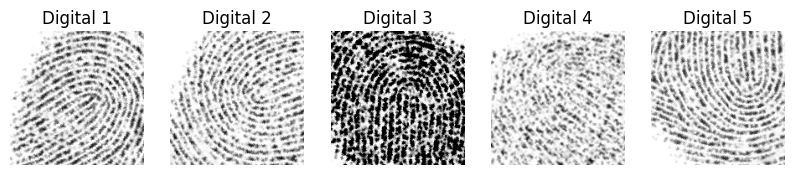

In [ ]:
# Caminho para as digitais da pessoa com id 00000
person_0_path = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00000"

# Listar todas as imagens no diretório
person_0_digitals = [os.path.join(person_0_path, img) for img in os.listdir(person_0_path) if img.endswith(".bmp")]

# Exibir os caminhos das primeiras 5 digitais da pessoa 0
print("Caminhos das primeiras 5 digitais:")
print(person_0_digitals[:5])

# Função para exibir as imagens
def show_images(image_paths, num_images=3):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = image.load_img(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Digital {i + 1}")
        plt.axis('off')
    plt.show()

# Exibir as primeiras 5 digitais
show_images(person_0_digitals, num_images=5)

## 4. Criação de pares de verificação
A função a seguir retorna duas listas:

pairs: Lista de tuplas, onde cada tupla contém dois caminhos de arquivos de imagem (um para a imagem de referência e outro para a imagem correspondente).

labels: Lista de labels (1 ou 0), indicando se as duas imagens no par são da mesma pessoa (1) ou pessoas diferentes (0).

In [ ]:
def create_verification_pairs(real_dir, train_dir, num_negatives_per_positive=1):
    pairs = []
    labels = []

    person_ids = [f"{i:05d}" for i in range(10)] # Lista de pessoas (00000 a 00009)

    for person_id in person_ids:
        # Imagem de referência (real_data)
        anchor_path = os.path.join(real_dir, f"{person_id}.bmp")

        # Pares POSITIVOS (mesma pessoa)
        positive_dir = os.path.join(train_dir, person_id)
        for img_name in os.listdir(positive_dir):
            if img_name.endswith(".bmp"):
                pairs.append((anchor_path, os.path.join(positive_dir, img_name)))
                labels.append(1)

        # Pares NEGATIVOS (pessoas diferentes)
        other_ids = [id for id in person_ids if id != person_id]
        for _ in range(num_negatives_per_positive * 80):  # Balanceamento
            other_id = random.choice(other_ids)
            other_dir = os.path.join(train_dir, other_id)
            other_img = random.choice(os.listdir(other_dir))
            pairs.append((anchor_path, os.path.join(other_dir, other_img)))
            labels.append(0)

    return pairs, labels

# Criar pares
pairs, labels = create_verification_pairs(real_data_path, train_data_path)

## 5. Pré-processamento das imagens

In [ ]:
def preprocess_image(image_path, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_bmp(img, channels=3)
    img = tf.image.resize(img, (160, 160))  # Garantir mesmo tamanho das imagens

    #Trecho opcional caso usuário queira fazer data augmentation
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)

    return tf.cast(img, tf.float32) / 255.0


def create_dataset(pairs, labels):
    anchor_images = []
    test_images = []
    for anchor, test in pairs:
        anchor_images.append(preprocess_image(anchor))
        test_images.append(preprocess_image(test))

    return tf.data.Dataset.from_tensor_slices((
        (tf.stack(anchor_images), tf.stack(test_images)),
        tf.convert_to_tensor(labels, dtype=tf.float32)
    )).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Divisão treino/validação
train_pairs, val_pairs, train_labels, val_labels = train_test_split(
    pairs, labels, test_size=0.2, random_state=42
)


train_ds = create_dataset(train_pairs, train_labels)
val_ds = create_dataset(val_pairs, val_labels)

## Arquitetura da rede

In [ ]:
def build_siamese_model():

    # Base network compartilhada
    input_layer = layers.Input(shape=(160, 160, 3))

    x = layers.Conv2D(32, (5,5), activation='relu')(input_layer)
    x = layers.MaxPooling2D(2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(256, (3,3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)


    base_model = Model(input_layer, x)

    # Duas entradas
    anchor_input = layers.Input(shape=(160, 160, 3), name='anchor_input')  # Alterado para 160x160
    test_input = layers.Input(shape=(160, 160, 3), name='test_input')  # Alterado para 160x160

    # Embedding resultado da CNN
    anchor_embedding = base_model(anchor_input)
    test_embedding = base_model(test_input)

    # Distância L1
    distance = layers.Lambda(
        lambda embeddings: tf.abs(embeddings[0] - embeddings[1])
    )([anchor_embedding, test_embedding])

    # Classificação
    output = layers.Dense(1, activation='sigmoid')(distance)

    return Model(inputs=[anchor_input, test_input], outputs=output)

# Criar o modelo
model = build_siamese_model()

# Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

#Resumo do modelo
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor_input (InputLayer) │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ test_input (InputLayer)   │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_24             │ (None, 256)            │        456,384 │ anchor_input[0][0],    │
│ (Functional)              │                        │                │ test_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_12 (Lambda)        │ (None, 256)            │              0 │ functional_24[0][0],   │
│                           │                        │                │ functional_24[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 1)              │            257 │ lambda_12[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 456,641 (1.74 MB)

 Trainable params: 456,321 (1.74 MB)

 Non-trainable params: 320 (1.25 KB)

## 7. Treinamento

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_auc'),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, monitor='val_loss')
    ]
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.5180 - auc: 0.5203 - loss: 0.7483 - precision: 0.5202 - recall: 0.4783 - val_accuracy: 0.5188 - val_auc: 0.4634 - val_loss: 0.6941 - val_precision: 0.5171 - val_recall: 0.8344 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6340 - auc: 0.6605 - loss: 0.6480 - precision: 0.6288 - recall: 0.7130 - val_accuracy: 0.5188 - val_auc: 0.5995 - val_loss: 0.6778 - val_precision: 0.5634 - val_recall: 0.2454 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6438 - auc: 0.7042 - loss: 0.6254 - precision: 0.6342 - recall: 0.6540 - val_accuracy: 0.4906 - val_auc: 0.6049 - val_loss: 0.7114 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6802 - auc: 0.7481 - loss: 0.5951 - precision: 0.6975 - recall: 0.6686 - val_accuracy: 0.5094 - val_auc: 0.6175 - val_loss: 0.7985 

## 8. Avaliação

In [ ]:
def evaluate_model(model, dataset):
    results = model.evaluate(dataset)
    print(f'''
    Loss: {results[0]:.2f}
    Accuracy: {results[1]*100:.2f}%
    Precision: {results[2]*100:.2f}%
    Recall: {results[3]*100:.2f}%
    AUC: {results[4]*100:.2f}%
    ''')

print("Avaliação no Conjunto de Validação:")
evaluate_model(model, val_ds)

Avaliação no Conjunto de Validação:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8744 - auc: 0.9604 - loss: 0.2706 - precision: 0.9149 - recall: 0.8336

    Loss: 0.31
    Accuracy: 85.62%
    Precision: 90.34%
    Recall: 80.37%
    AUC: 95.23%
    


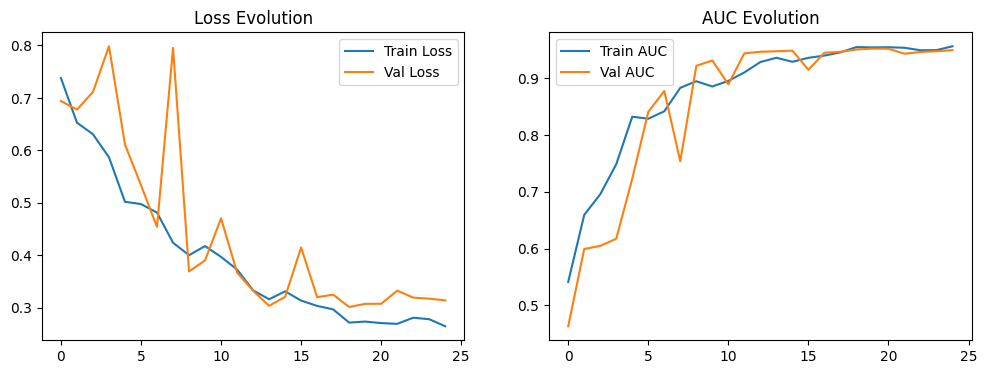

In [ ]:
#Gráficos de métricas ao longo do treinamento
def plot_training(history):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Evolution')
    plt.legend()

    # AUC
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Evolution')
    plt.legend()

    plt.show()

plot_training(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


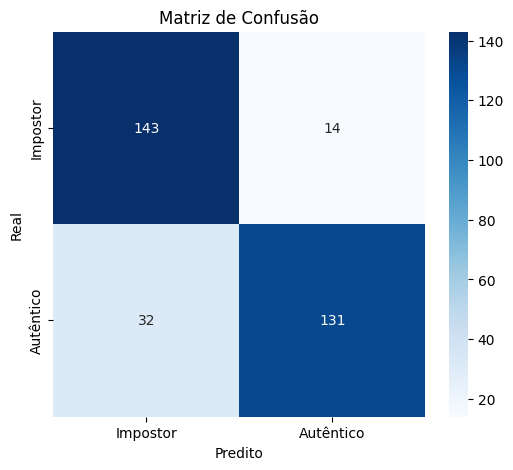

In [ ]:
#Matriz de confusão
def plot_confusion_matrix(model, dataset, class_names=['Impostor', 'Autêntico']):

    y_true = []
    y_pred = []

    # Fazer previsões no conjunto de dados
    for (anchor, test), labels in dataset:
        predictions = model.predict([anchor, test])
        y_pred.extend(predictions.flatten())
        y_true.extend(labels.numpy().flatten())

    # Converter previsões para 0 ou 1
    y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

    # Gerar matriz de confusão
    cm = confusion_matrix(y_true, y_pred_binary)

    # Plotar a matriz de confusão
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

plot_confusion_matrix(model, val_ds)

## 9. Exemplos de verificação e visualização dos resultados

In [ ]:
def verify_fingerprint(anchor_path, test_path, threshold=0.5):
    # Pré-processamento
    anchor = preprocess_image(anchor_path)
    test = preprocess_image(test_path)

    # Predição
    similarity = model.predict([tf.expand_dims(anchor, 0), tf.expand_dims(test, 0)])[0][0]

    # Decisão
    if similarity > threshold:
        return f"Digital VERIFICADA (similaridade: {similarity:.2f})"
    else:
        return f"FALSIFICAÇÃO detectada (similaridade: {similarity:.2f})"

# Exemplo de uso:

#Verificada
anchor_example1 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/real_data/00001.bmp"
test_example1 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00001/00001_06.bmp"

#Falsificada
anchor_example2 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/real_data/00007.bmp"
test_example2 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00008/00008_70.bmp"

#Verificada
anchor_example3 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/real_data/00003.bmp"
test_example3 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00003/00003_65.bmp"

#Falsificada
anchor_example4 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/real_data/00004.bmp"
test_example4 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00005/00005_62.bmp"

#Falsificada (exemplo dificil)
anchor_example5 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/real_data/00004.bmp"
test_example5 = "/content/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B/dataset/train_data/00005/00005_79.bmp"

result1 = verify_fingerprint(anchor_example1, test_example1)
result2 = verify_fingerprint(anchor_example2, test_example2)
result3 = verify_fingerprint(anchor_example3, test_example3)
result4 = verify_fingerprint(anchor_example4, test_example4)
result5 = verify_fingerprint(anchor_example5, test_example5)

print(result1)
print(result2)
print(result3)
print(result4)
print(result5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Digital VERIFICADA (similaridade: 0.86)
FALSIFICAÇÃO detectada (similaridade: 0.06)
Digital VERIFICADA (similaridade: 0.98)
FALSIFICAÇÃO detectada (similaridade: 0.08)
Digital VERIFICADA (similaridade: 0.79)


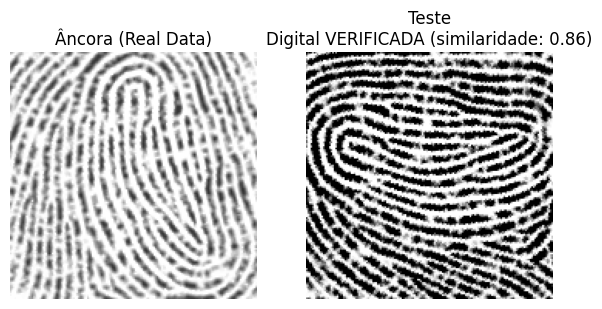

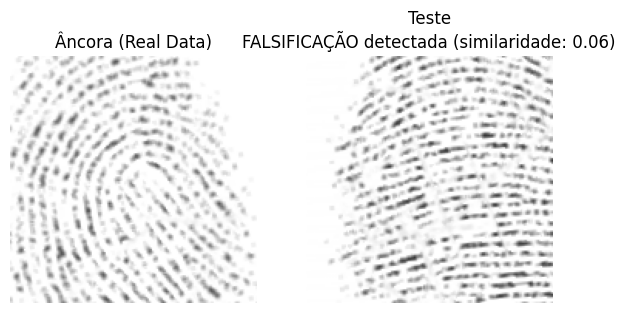

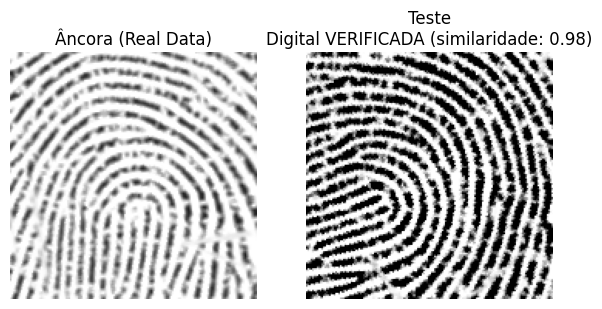

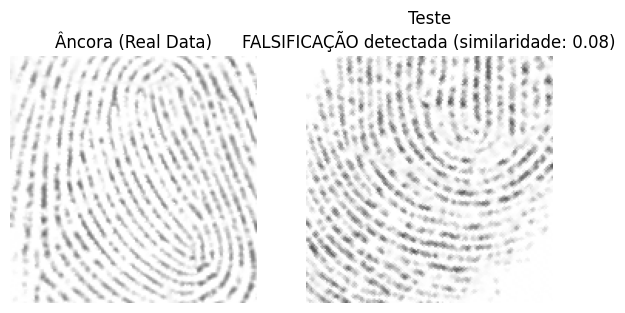

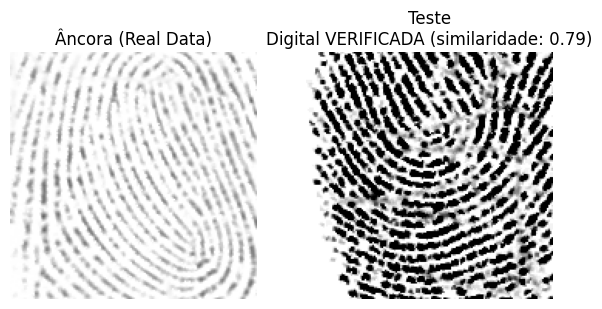

In [ ]:
# Plotar pares
def plot_pairs(anchor, test, prediction):
    plt.figure(figsize=(7,5))

    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.load_img(anchor))
    plt.title("Âncora (Real Data)")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.load_img(test))
    plt.title(f"Teste\n{prediction}")
    plt.axis('off')

    plt.show()

# Testar com exemplos
plot_pairs(anchor_example1, test_example1, result1)
plot_pairs(anchor_example2, test_example2, result2)
plot_pairs(anchor_example3, test_example3, result3)
plot_pairs(anchor_example4, test_example4, result4)
plot_pairs(anchor_example5, test_example5, result5) #exemplo dificil